In [1]:
# to auto reload the modified module
% load_ext autoreload
% autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import random
import os
from progressive_nn import InitialColumnProgNN
from utils import *

/home/deep3072/anaconda2/envs/tu36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def check_obj(obj_str):
    obj = eval(obj_str)
    obj_type = type(obj)
    print(obj_str
        , obj_type
        , end = ' '
        )
    if obj_type == np.ndarray:
        print(obj.shape)
    else:
        try:
            iterator = iter(obj)
        except TypeError:
            # not iterable
            print(obj)
        else:
            # iterable
            print(len(obj))

In [4]:
# # session settings
gpu_id = '1'
session = create_session(gpu_id=gpu_id)

In [ ]:
# seed settings
seed = int(os.getenv("SEED", 12))
tf.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
try_reg = True
if try_reg:
#         X_data = np.random.random((6000))[:, np.newaxis]*100
#         noise = np.random.normal(0, 0.05, X_data.shape).astype(np.float32)*0
#         y_data = X_data*2 + 1 + noise
    X_data = np.linspace(-1,1,300, dtype=np.float32)[:, np.newaxis]
    np.random.shuffle(X_data)
    noise = np.random.normal(0, 0.05, X_data.shape).astype(np.float32)
    y_data = np.square(X_data) - 0.5 + noise
    print('X_data',X_data.shape,'\n',X_data[:5])
    print('y_data',y_data.shape,'\n',y_data[:5])

    input_dims = X_data.shape[1]
    col_0 = InitialColumnProgNN(
        input_dims=input_dims
        , output_dims=1
        , session=session
        , dtype_X=tf.float32, dtype_y=tf.float32
    )
    col_0.add_fc(10,activation_func=tf.nn.relu)
#     col_0.add_fc(1024,activation_func=tf.nn.relu)
    col_0.add_fc(1,activation_func=None
        # ,output_layer=True
        )
    col_0.compile_nn(
#         loss=tf.reduce_mean(tf.reduce_sum(tf.square(col_0.ys - col_0.prediction),reduction_indices=[1]))
        loss=tf.losses.mean_squared_error(col_0.ys,col_0.prediction)
        ,opt=tf.train.AdamOptimizer(learning_rate=1e-3)
#         ,opt=tf.train.GradientDescentOptimizer(learning_rate=1e-1)
#         ,mectrics=[]
    )
    col_0.train(
        X=X_data
        , y=y_data
        , batch_size=32
        , n_epochs=1000
        , display_steps=50
    )


X_data (300, 1) 
 [[-0.4381271 ]
 [ 0.67892975]
 [ 0.5852843 ]
 [ 0.6187291 ]
 [ 0.33779263]]
y_data (300, 1) 
 [[-0.40578312]
 [-0.02366678]
 [-0.23387113]
 [-0.05727664]
 [-0.37502772]]
Layer 1 : FC, input shape = [None, 1] , out_size = 10
Layer 2 : FC, input shape = [None, 10] , out_size = 1
Epoch 1 , step 0 , loss= 0.2062944 
Epoch 6 , step 5 , loss= 0.095764205 
Epoch 12 , step 1 , loss= 0.10385649 
Epoch 17 , step 6 , loss= 0.06631231 
Epoch 23 , step 2 , loss= 0.08670224 
Epoch 28 , step 7 , loss= 0.095092155 
Epoch 34 , step 3 , loss= 0.08650133 
Epoch 39 , step 8 , loss= 0.07624758 
Epoch 45 , step 4 , loss= 0.05866401 
Epoch 51 , step 0 , loss= 0.06275883 
Epoch 56 , step 5 , loss= 0.04633624 
Epoch 62 , step 1 , loss= 0.053709347 
Epoch 67 , step 6 , loss= 0.04106062 
Epoch 73 , step 2 , loss= 0.025521887 
Epoch 78 , step 7 , loss= 0.025080856 
Epoch 84 , step 3 , loss= 0.025120003 
Epoch 89 , step 8 , loss= 0.019885067 
Epoch 95 , step 4 , loss= 0.013985058 
Epoch 101 , ste

Plotting loss...


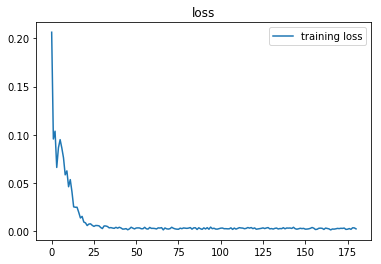

Plotting metrics...
no metrics to plot


In [6]:
if try_reg:
    col_0.plt_loss()
    col_0.plt_metrics()

In [7]:
try_cls = True
if try_cls:
    from tensorflow.examples.tutorials.mnist import input_data

    mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
    X_train = mnist.train.images#.astype(np.float64)
    y_train = mnist.train.labels#.astype(np.float64)
    X_val = mnist.validation.images
    y_val = mnist.validation.labels
    X_test = mnist.test.images
    y_test = mnist.test.labels
    check_obj('X_train')
    check_obj('y_train')
    input_dims = X_train.shape[1]
    output_dims = y_train.shape[1]
    check_obj('input_dims')
    check_obj('output_dims')
    col_cls_0 = InitialColumnProgNN(
        input_dims=input_dims
        , output_dims=output_dims
        , session=session
        , dtype_X=tf.float32
        , dtype_y=tf.float32)
    col_cls_0.add_fc(512,activation_func=tf.nn.relu)
    col_cls_0.add_fc(256,activation_func=tf.nn.relu)
    col_cls_0.add_fc(128,activation_func=tf.nn.relu)
    col_cls_0.add_fc(output_dims,activation_func=tf.nn.softmax)
    col_cls_0.compile_nn(
        loss=tf.losses.softmax_cross_entropy(col_cls_0.ys,col_cls_0.logits)
        , opt=tf.train.AdamOptimizer(learning_rate=1e-3)
        , metrics = ['acc'])
    col_cls_0.train(
        X=X_train
        ,y=y_train
        ,val_set=[X_val,y_val]
        ,batch_size=512
        ,n_epochs=10
        ,display_steps=100)
    

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
X_train <class 'numpy.ndarray'> (55000, 784)
y_train <class 'numpy.ndarray'> (55000, 10)
input_dims <class 'int'> 784
output_dims <class 'int'> 10
Layer 1 : FC, input shape = [None, 784] , out_size = 512
Layer 2 : FC, input shape = [None, 512] , out_size = 256
Layer 3 : FC, input shape = [None, 256] , out_size = 128
Layer 4 : FC, input shape = [None, 128] , out_size = 10
Epoch 1 , step 0 , loss= 2.3004405 acc = 0.203125 , val_loss= 2.294193 val acc = 0.205 
Epoch 1 , step 100 , loss= 0.17814937 acc = 0.9589844 , val_loss= 0.16111988 val acc = 0.9524 
Epoch 2 , step 93 , loss= 0.12448112 acc = 0.96484375 , val_loss= 0.10370858 val acc = 0.9674 
Epoch 3 , step 86 , loss= 0.053946175 acc = 0.9824219 , val_loss= 0.09026974 val acc = 0.9732 
Epoch 4 , step 79 , loss= 0.034038175 acc = 0.9980469 , val_los

Plotting loss...


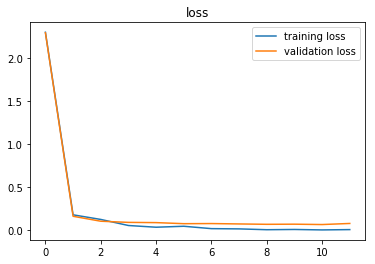

Plotting metrics...


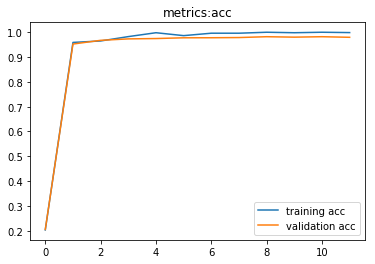

In [8]:
if try_cls:
    col_cls_0.plt_loss()
    col_cls_0.plt_metrics()